# Final Assignment: Customer Return Prediciton
### Business Analytics and Data Science - Winter 2020/2021 - Prof. Dr. Stefan Lessmann
### Submission by David Schulte

## Problem statement (as given by the instructor)

Customers send back a substantial part of the products that they purchase online. Return shipping is expensive for online platforms and return orders are said to reach 50% for certain industries and products. Nevertheless, free or inexpensive return shipping has become a customer expectation and de-facto standard in the fierce online competition on clothing, but shops have indirect ways to influence customer purchase behavior. For purchases where return seems likely, a shop could, for example, restrict payment options or display additional marketing communication.

For this assignment, you are provided with real-world data by an online retailer. Your task is to identify the items that are likely to be returned. When a customer is about to purchase a item, which is likely to be returned, the shops is planning to show a warning message. Your task is to build a targeting model to balance potential sales and return risk in order to optimize shop revenue. The data you receive is artificially balanced (1:1 ratio between returns and non-returns).



The metric which will be used to evaluate the final predictions will be the minimization of the given cost matrix, in which `v` is the price of the item.

![Cost matrix](costmatrix.png)

## Solution

First, we will import from librabries commonly used in Data Science. <br/>
Additionally, I wrote several classes, which we want to import here. This makes this notebook more readable.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from DataCleaner import DataCleaner
from DataTransformer import DataTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve
from Model import Model
pd.set_option('mode.chained_assignment', None)
seed = 888


## Explanatory data analysis and data preparation

We will load the data into a `pandas dataframe`.

In [2]:
df_known = pd.read_csv("BADS_WS2021_known.csv", index_col='order_item_id')

Let us have a first look at the data.

In [3]:
df_known.head(10)

,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,return
order_item_id,,,,,,,,,,,,,
1,2016-06-22,2016-06-27,643,38,navy,30,49.90,30822,Mrs,1969-04-17,Saxony,2016-06-23,0
2,2016-06-22,NaN,337,152,grey,30,19.95,30822,Mrs,1969-04-17,Saxony,2016-06-23,0
3,2016-06-22,2016-06-27,270,xxl,grey,49,79.90,30823,Mrs,1970-04-22,Baden-Wuerttemberg,2015-03-15,1
4,2016-06-22,2016-06-27,142,xxl,grey,49,99.90,30823,Mrs,1970-04-22,Baden-Wuerttemberg,2015-03-15,0
5,2016-06-22,2016-06-27,561,xxl,grey,3,14.90,30823,Mrs,1970-04-22,Baden-Wuerttemberg,2015-03-15,1
6,2016-06-22,2016-06-27,579,xxl,grey,3,19.90,30823,Mrs,1970-04-22,Baden-Wuerttemberg,2015-03-15,1
7,2016-06-22,2016-06-27,72,41,grey,1,119.90,30823,Mrs,1970-04-22,Baden-Wuerttemberg,2015-03-15,0
8,2016-06-22,2016-06-27,106,50,white,6,39.90,30823,Mrs,1970-04-22,Baden-Wuerttemberg,2015-03-15,1
9,2016-06-22,2016-06-27,195,xxl,blue,46,13.90,30823,Mrs,1970-04-22,Baden-Wuerttemberg,2015-03-15,1


In [4]:
df_known.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 1 to 100000
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   order_date     100000 non-null  object 
 1   delivery_date  90682 non-null   object 
 2   item_id        100000 non-null  int64  
 3   item_size      100000 non-null  object 
 4   item_color     100000 non-null  object 
 5   brand_id       100000 non-null  int64  
 6   item_price     100000 non-null  float64
 7   user_id        100000 non-null  int64  
 8   user_title     100000 non-null  object 
 9   user_dob       91275 non-null   object 
 10  user_state     100000 non-null  object 
 11  user_reg_date  100000 non-null  object 
 12  return         100000 non-null  int64  
dtypes: float64(1), int64(4), object(8)
memory usage: 10.7+ MB


We can instantly make the following observations.<br/>
- The data contains 12 feature variables and our target *return*.
- There are 100,000 data points.
- Each row corresponds to one item in an individual order and and order can consist of several rows.
- There are missing values for the features `delivey_date` and `user_dob`.

Our data has the following features:
- `order_date`: date an item was ordered
- `delivery_date`: date an item was delivered
- `item_id`: unique ID of the item
- `item_size`: size of the item
- `item_price`: price of the item
- `user_title`: customer title
- `user_dob`: date of birth of the customer
- `user_state`: state of the customer
- `user_reg_date`: date of registration of the customer



### Data type conversion
Before we focus more on the data, we want to typecast the features to more suitable datatypes. <br/>
We will use the class DataTransformer, that I wrote for this project. It is a custom transformer that has several functions that help us with the process of data cleaning and feature engineering. It is compatible with `scikit-learn `. This brings some advantages, as we will see later in this notebook.

In [5]:
transformer = DataTransformer()

We will change the datatypes of our features. We will downcast the numerical values, as neither of them needs 64 bits storage.
The dates will be converted to the pandas datatype `datetime`. The other features with type `object` will be converted into `category`. <br/>
Although the IDs are categorical features, we will leave them as they are for now, because we can visualize them better this way.

In [6]:
df_known = transformer.convert_data_types(df_known)

In [7]:
df_known.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 1 to 100000
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   order_date     100000 non-null  datetime64[ns]
 1   delivery_date  90682 non-null   datetime64[ns]
 2   item_id        100000 non-null  int32         
 3   item_size      100000 non-null  category      
 4   item_color     100000 non-null  category      
 5   brand_id       100000 non-null  int32         
 6   item_price     100000 non-null  float32       
 7   user_id        100000 non-null  int32         
 8   user_title     100000 non-null  category      
 9   user_dob       91275 non-null   datetime64[ns]
 10  user_state     100000 non-null  category      
 11  user_reg_date  100000 non-null  datetime64[ns]
 12  return         100000 non-null  int64         
dtypes: category(4), datetime64[ns](4), float32(1), int32(3), int64(1)
memory usage: 6.5 MB


Our data is now easier to work with and memory usage has decreased significantly.

### Visualization of the numerical features
Let us have a closer look at the data.

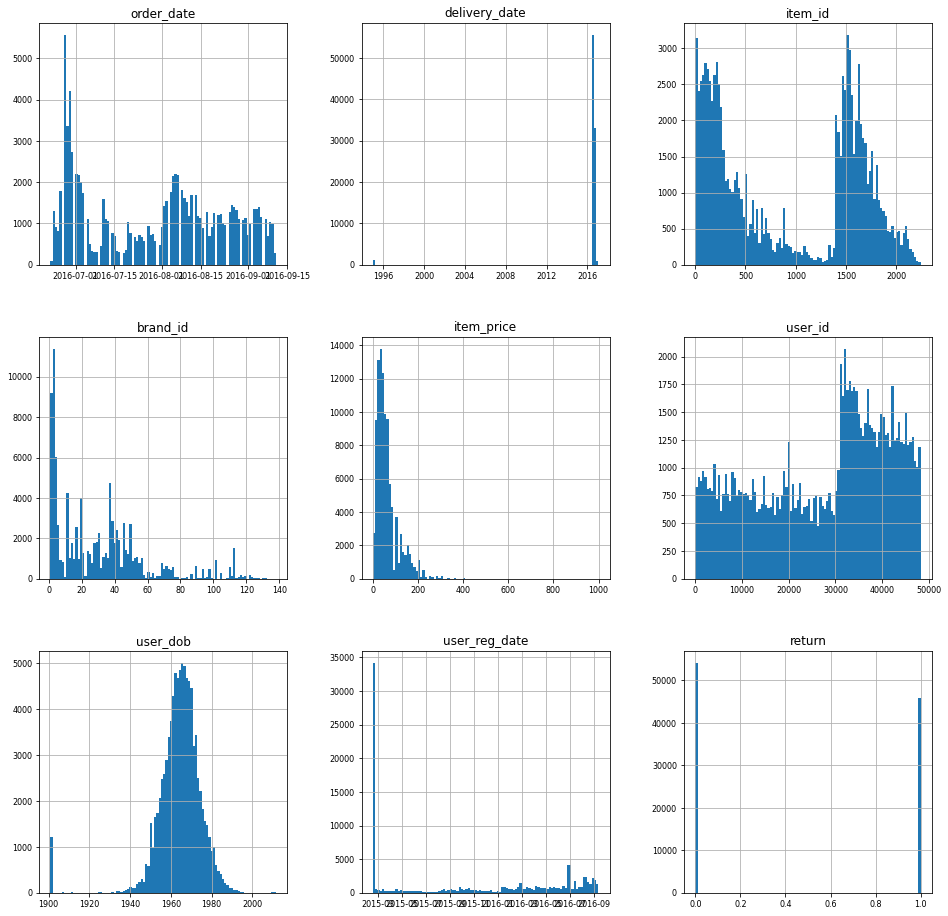

In [8]:
df_known.hist(figsize=(16, 16), bins=100, xlabelsize=8, ylabelsize=8); # produces one histogram per feature

We make the following observations:
- All items were ordered between July and September of 2016.
- There are some wrong values for the delivery date.
- There are big differences in how often a specific item was ordered. Also, the histogram has a shape of two peaks. This could be the result of the system that was used to assign items their ID, but we do not know, how to interpret it.
- Similarly to the items, some brands are being ordered more often than others.
- The histogram of item prices is skewed right. Also, there are some extreme outlieres.
- There is a visible pattern in the histogram of user IDs. Users that have a higher ID than 3000 seem to order more. This also could be the result of the assignment of IDs.
- The date of birth of users has some extreme values, namely around 1900. These values are not believable. The other values seem to be approximately normally distributed.
- Most registration dates of users are at a specific date in 2015, which is the earliest of all values. It is likely that users, whose registration date has this label, registered at or before this date. Apart from that, there seems to be a slight upwards-trend towards the future.
- As in the data description, the rows with return and not returned items are artificially balanced. We have slightly more not returned items in our data set.

### Comparing known and unknown data
Now, we will inspect the unknown data to see, if it is similar to the known data.

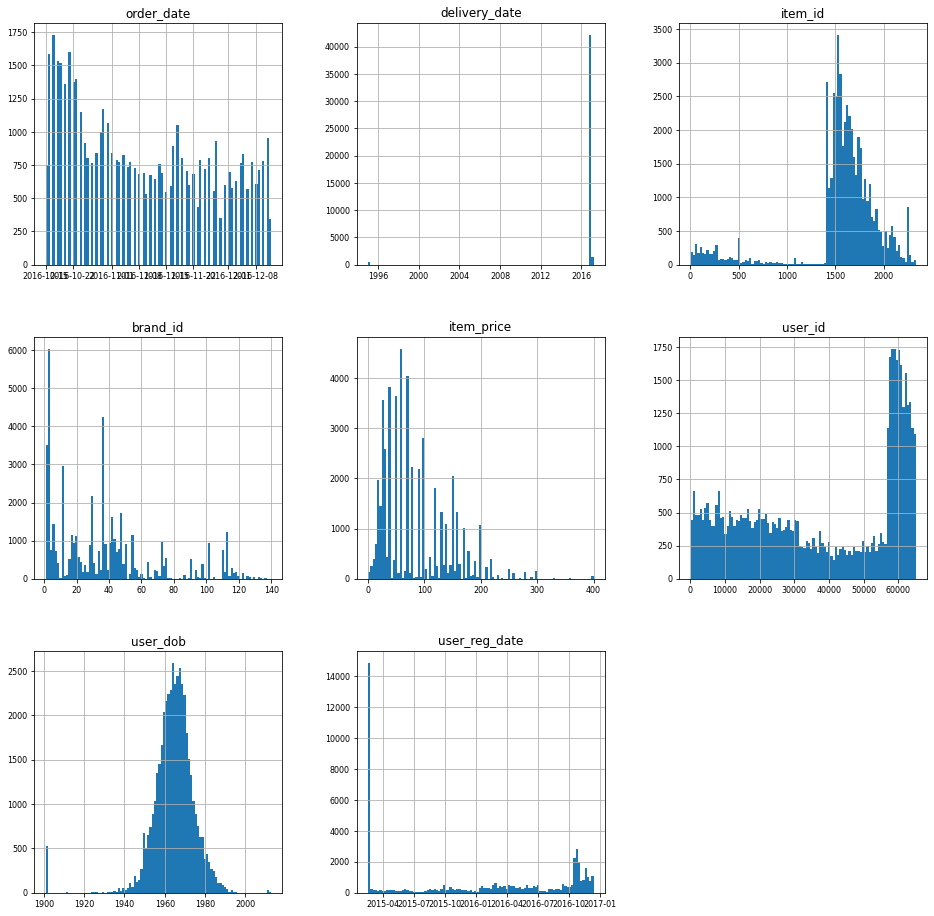

In [9]:
df_unknown = pd.read_csv("BADS_WS2021_unknown.csv", index_col='order_item_id')
df_unknown = transformer.convert_data_types(df_unknown)
df_unknown.hist(figsize=(16, 16), bins=100, xlabelsize=8, ylabelsize=8); # produces one histogram per feature

The histograms are mostly very similar. However, the following differences stand out:
- The items were orderes between October and December of 2016.
- Items with lower IDs were not ordered as often as before. One could imagine that items with lower IDs are more in demand around summer and early fall than in winter, but that is pure speculation.
- A lot of the orders are from users with higher user IDs than we have seen before.

Before continuing, we want to make sure that the user IDs from both datasets belong to the same users and no IDs were being reassigned. To do this, we will test, if a user with a specific ID that is contained in both data sets has the same attributes, namely `user_dob`, `user_title` and `user_state`.

In [10]:
common_users = np.intersect1d(df_known.user_id, df_unknown.user_id).tolist()

for user in common_users:
    
    users_identical = True
    
    known_state = pd.unique(df_known.loc[df_known['user_id']==user,'user_state'])
    unknown_state = pd.unique(df_unknown.loc[df_unknown['user_id']==user,'user_state'])
    known_title = pd.unique(df_known.loc[df_known['user_id']==user,'user_title'])
    unknown_title = pd.unique(df_unknown.loc[df_unknown['user_id']==user,'user_title'])
    known_dob = pd.unique(df_known.loc[df_known['user_id']==user,'user_dob'])
    unknown_dob = pd.unique(df_unknown.loc[df_unknown['user_id']==user,'user_dob'])

    if unknown_state[0] != known_state[0] or unknown_title[0] != known_title[0] or unknown_dob[0] != known_dob[0]:
        users_identical = False
        
if users_identical:
    print("The user IDs belong to the same users.")
else:
    print("The user IDs do not belong to the same users.")

The user IDs belong to the same users.


We will do the same with the items, by checking, if they have the same `brand_id`.

In [11]:
common_items = np.intersect1d(df_known.item_id, df_unknown.item_id).tolist()

for item in common_items:
    
    items_identical = True
    
    known_brand = pd.unique(df_known.loc[df_known['item_id']==item,'brand_id'])
    unknown_brand = pd.unique(df_unknown.loc[df_unknown['item_id']==item,'brand_id'])
    
    if unknown_brand[0] != known_brand[0]:
        users_identical = False
        
if items_identical:
    print("The item IDs belong to the same items.")
else:
    print("The item IDs do not belong to the same items.")

The item IDs belong to the same items.


The IDs are in fact consistent.

### Exploring of the categorical variables

In [12]:
df_known['item_size'].value_counts()

l       12347
xl      10979
m       10190
xxl      8966
40       7693
        ...  
3834        1
12+         1
105         1
4034        1
3132        1
Name: item_size, Length: 102, dtype: int64

There are a lot of different item sizes. There may be a way to regroup them, but we will further investigate this. The reason is that there is no indication, why the size of an item should influence the probability of it being returned.

In [13]:
df_known['item_color'].value_counts()

black          18640
blue           10625
brown           8734
grey            8708
red             7264
               ...  
copper coin        7
amethyst           5
avocado            4
creme              4
opal               2
Name: item_color, Length: 77, dtype: int64

In [14]:
df_known['user_id'].nunique()

19205

In [15]:
df_known['user_title'].value_counts()

Mrs             95429
Mr               3915
Family            414
Company           128
not reported      114
Name: user_title, dtype: int64

We see that the vast majority of orders were being done by female customers. Also, some titles were not reported.

<AxesSubplot:xlabel='user_title'>

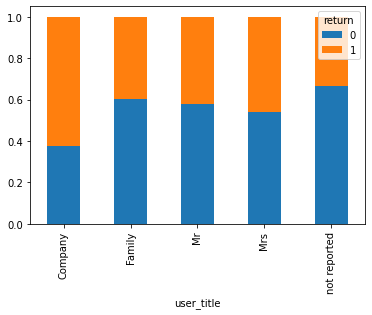

In [16]:
user_title = df_known.groupby(['return', 'user_title']).size().reset_index().pivot(columns='return', index='user_title', values=0)
                                                                       
#user_title.plot(kind='bar', stacked=True);
user_title.div(user_title.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)

In [17]:
df_known.loc[df_known['user_title']=='Company', 'user_id'].value_counts()

3633     24
36816    18
347      17
46613    16
10132    10
46360     7
32416     7
39520     4
37934     4
47241     3
42983     3
43704     3
33343     2
24884     2
35885     2
20045     1
31373     1
8150      1
41880     1
45426     1
29182     1
Name: user_id, dtype: int64

The return rate of companies is different. However, we will not consider it, because there are so few companies in our dataset.

<AxesSubplot:xlabel='user_state'>

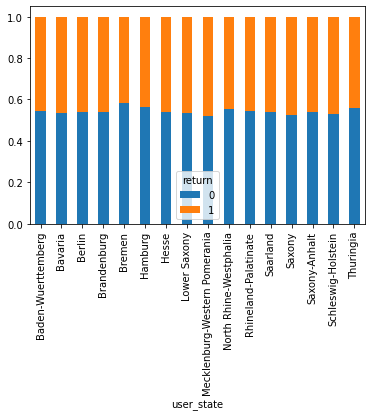

In [18]:
user_state = df_known.groupby(['return', 'user_state']).size().reset_index().pivot(columns='return', index='user_state', values=0)
                                                                       
#user_title.plot(kind='bar', stacked=True);
user_state.div(user_state.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)

The average return rates of the different states are very similar. That is what we expected. We will later drop this feature.

### Gaps in the data
We already noticed that we have gaps in the data in two of our features. Let us take a closer look.

<AxesSubplot:ylabel='order_item_id'>

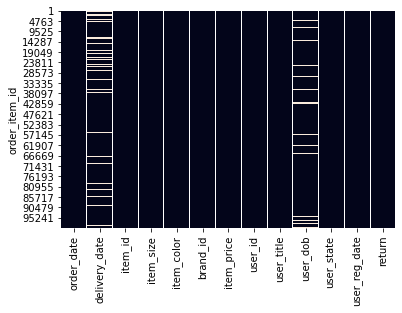

In [19]:
sns.heatmap(df_known.isnull(), cbar=False)

There is no pattern visible in the gaps, therefore they are not related to each other. This what we would expect. <br/>
An explanation for the missing values for `user_dob` could be that users are not required to fill in this information. <br/>
The missing values for `delivery_date`, however, are more interesting.

In [20]:
df_known.loc[df_known['delivery_date'].isnull()]

,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,return
order_item_id,,,,,,,,,,,,,
2,2016-06-22,NaT,337,152,grey,30,19.950001,30822,Mrs,1969-04-17,Saxony,2016-06-23,0
56,2016-06-23,NaT,5,l,white,5,69.900002,30828,Mrs,1966-05-13,Lower Saxony,2016-01-21,0
64,2016-06-23,NaT,211,40,turquoise,1,69.900002,22948,Mrs,1957-03-11,Baden-Wuerttemberg,2015-02-17,0
65,2016-06-23,NaT,55,40,purple,1,89.900002,22948,Mrs,1957-03-11,Baden-Wuerttemberg,2015-02-17,0
66,2016-06-23,NaT,74,40,pink,24,69.900002,22948,Mrs,1957-03-11,Baden-Wuerttemberg,2015-02-17,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99953,2016-09-11,NaT,1508,42,dark denim,113,59.900002,48234,Mrs,1962-10-02,Hesse,2016-09-12,0
99954,2016-09-11,NaT,1498,42,green,6,59.900002,48234,Mrs,1962-10-02,Hesse,2016-09-12,0
99955,2016-09-11,NaT,1412,40,blue,54,119.900002,48234,Mrs,1962-10-02,Hesse,2016-09-12,0


It looks like, the items without delivery date were not being returned.

In [21]:
items_no_ddate = df_known.loc[df_known['delivery_date'].isnull()]
print("There are {} items without delivery date".format(len(items_no_ddate)))
print("Out of those items {} were returned.".format(items_no_ddate['return'].sum()))

There are 9318 items without delivery date
Out of those items 0 were returned.


That is very interesting. Items without delivery date were not being returned. We have two possible explanations for that.
1) Delivery dates are determined, after the items have been delivered. The users canceled their order before the items were shipped, which would not count as a return.<br/>
2) Delivery dates are the predicted dates of delivery. The items can not be delivered. What speaks against this, is that a user should not be allowed by the ordering system to order an item that can not be delivered.

We will assume that the first explanation is right. The fact that we have a sound explanation for this rule and that the data supports our assumption so clearly, we will use it in our model.
We could either create a boolean value `delivered` and hope that our model will learn to apply our rule by itself, or we could hardcode it. In our model, we will use the latter approach, because the association is so strict.

Let us now take a step back and think about the information `delivery_date` gives us. The value of this feature seems to be determined after the customer submits an order. If we recall the use case of our prediction model, we quickly realize that we will not have this information at the time our model makes new predictions. Therefore, we are not able to use `delivery_date` as a feature. Also a model that predicts our unknown data will not be applicable to the case it was designed for.

To deal with this problem, will create a parameter in our model, which we call `user_delivery_dates`.
- If it is set to `True`, we will the feature in our model. We will also use the hardcoded rule discussed above.
- If it is set to `False`, the feature will be ignored. This ensures that our model works in the actual use case.

We will for now use the feature, as it will likely improve the prediction of our unknown data. Furthermore, it is possible that we misunderstood the process, in which the feature values are determined. The best way to deal with this confusion would be to ask our retail company about it. <br/>

For now, we will not fill the gaps of our data. The reason is that we will later drop both of the affected feature values. Before, we will construct features that use them and fill the gaps in these features.

### Further exploration

<AxesSubplot:xlabel='return'>

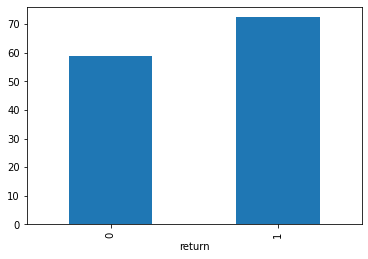

In [22]:
df_known.groupby('return')['item_price'].mean().plot(kind='bar')

We can see that the average price of returned items is higher than the one of not returned items.

In [23]:
df_known.loc[df_known['item_price']==0]

,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,return
order_item_id,,,,,,,,,,,,,
203,2016-06-23,2016-06-26,157,unsized,purple,32,0.0,12373,Mrs,1958-06-07,Lower Saxony,2015-02-26,0
217,2016-06-23,2016-06-26,157,unsized,purple,32,0.0,30852,Mrs,1969-03-30,Saxony,2015-06-21,1
219,2016-06-23,2016-06-27,157,unsized,purple,32,0.0,18671,Mrs,1955-11-05,North Rhine-Westphalia,2015-02-17,0
352,2016-06-23,2016-06-27,157,unsized,purple,32,0.0,12388,Mrs,1962-01-16,North Rhine-Westphalia,2015-11-01,0
353,2016-06-23,2016-06-27,157,unsized,purple,32,0.0,12388,Mrs,1962-01-16,North Rhine-Westphalia,2015-11-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96409,2016-09-07,2016-10-29,1472,unsized,brown,60,0.0,47558,Mrs,1971-10-25,Schleswig-Holstein,2015-07-09,0
97232,2016-09-08,2016-10-02,2025,unsized,grey,86,0.0,34189,Mrs,1963-09-08,Bavaria,2016-07-01,0
97434,2016-09-08,2016-10-29,1472,unsized,brown,60,0.0,47745,Mrs,1951-07-13,Baden-Wuerttemberg,2015-11-23,0


There are items that have a price of 0.

In [24]:
df_known.loc[df_known['item_price']==0, 'item_size'].value_counts()

unsized    395
40           1
1            0
42+          0
48           0
          ... 
29           0
28           0
27           0
26           0
xxxl         0
Name: item_size, Length: 102, dtype: int64

Excluding one data point, all those items have the size label `unsized`.

In [25]:
df_known.loc[df_known['item_price']==0, 'return'].mean()

0.11868686868686869

Some users returned those free items. That would be a very uncommon behavior, if the items were actually free. We are not sure what to make of this, but will create a boolean feature that is tells us, if the item is labeled as free.

### Feature Engineering
First, we will create the following features. <br/>
- `user_age`: The user's age at the order date. We just count the days between `user_dob` and `order_date` and divide them by 365. This is a good enough approximation.
- `item_is_free`: A boolean feature that is `True`, if the item price is zero, and `False` otherwise.

If we have set `user_delivery_dates`, we will also create the following two features:
- `delivery_span`: The days between order and delivery.
- `order_delivered`: A boolean feature that is true, if we have a value for `delivery_date`.


In [26]:
df_known = transformer.create_features_independent(df_known)

We will also create several features that are dependent on other data points and labels. <br/>
When doing so, one has to be very careful in order to prevent data leakage. When evaluating our model, the training data must not contain any information that is determined by the test data. Also, the features of our test data must not be computed using test data labels. <br/>
We will keep that in mind, and construct this features differently for training and test data. Our transformer inherits from the `scikit-learn` class `TransformerMixin`. This enables us to make this distinction in a very elegant way. <br/>
We will create the following dependent features:
- `order_num_items`: The number of items in the order.
- `item_multiple_orders`: A boolean feature that is `True`, if a user ordered multiple items with the same ID at the same day.
- `user_orders`:  The number of items a user has ordered overall.
- `item_popularity`: The number the item with the specific ID was ordered overall.
- `item_color_popularity`: The number of sales of items with the specific color.

The following features will be computed using labels. Therefore, we will compute them differently for training and test data:
- `user_avg_return`: The average return rate of the user.
    - training data: We will compute the average return of the specific user.
    - test data: If the specific user is also contained in the training data, we will use the return rate computed in the training data. Otherwise, we will assign the data point the average of all user return rates of the training data.
- `item_avg_return`: The average return rate of the item.
    - training data: We will compute the average return of the specific item.
    - test data: If the specific item is also contained in the training data, we will use the return rate computed in the training data. Otherwise, we will assign the data point the average of all item return rates of the training data.

For now, we will regard the whole dataset as training data, as we want to first see our new features.

In [27]:
X = df_known.drop('return', axis=1).copy()
y = df_known['return'].copy()

transformer.fit(X,y)

X = transformer.create_features_dependent(X)
df_known = pd.concat([X,y], axis=1)


### Dropping unnecessary features
We will drop the following features:

In [28]:
df_known = transformer.drop_columns(df_known)

Our data now looks like this:

In [29]:
df_known

,item_price,user_age,item_is_free,delivery_span,order_delivered,order_num_items,item_multiple_orders,user_orders,item_popularity,item_color_popularity,user_avg_return,item_avg_return,return
order_item_id,,,,,,,,,,,,,
1,49.900002,47.213699,False,5.0,True,2,False,3.0,22,314,0.000000,0.181818,0
2,19.950001,47.213699,False,NaN,False,2,False,3.0,52,8708,0.000000,0.096154,0
3,79.900002,46.200000,False,5.0,True,9,False,17.0,81,8708,0.588235,0.506173,1
4,99.900002,46.200000,False,5.0,True,9,False,17.0,228,8708,0.588235,0.535088,0
5,14.900000,46.200000,False,5.0,True,9,False,17.0,137,8708,0.588235,0.386861,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99996,29.900000,57.517808,False,1.0,True,2,True,4.0,221,10625,0.500000,0.502262,0
99997,29.900000,57.517808,False,1.0,True,2,True,4.0,221,8734,0.500000,0.502262,0
99998,26.900000,31.553425,False,-7925.0,True,2,True,3.0,98,18640,0.000000,0.448980,0


In [30]:
df_known.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 1 to 100000
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   item_price             100000 non-null  float32
 1   user_age               91275 non-null   float64
 2   item_is_free           100000 non-null  bool   
 3   delivery_span          90682 non-null   float32
 4   order_delivered        100000 non-null  bool   
 5   order_num_items        100000 non-null  int32  
 6   item_multiple_orders   100000 non-null  bool   
 7   user_orders            100000 non-null  float32
 8   item_popularity        100000 non-null  int32  
 9   item_color_popularity  100000 non-null  int32  
 10  user_avg_return        100000 non-null  float32
 11  item_avg_return        100000 non-null  float32
 12  return                 100000 non-null  int64  
dtypes: bool(3), float32(5), float64(1), int32(3), int64(1)
memory usage: 5.6 MB


Because we used features with missing values to compute `user_age` and `delivery_span`, there are still gaps in the data. We will handle that in the following sections.

### Visualization of new features

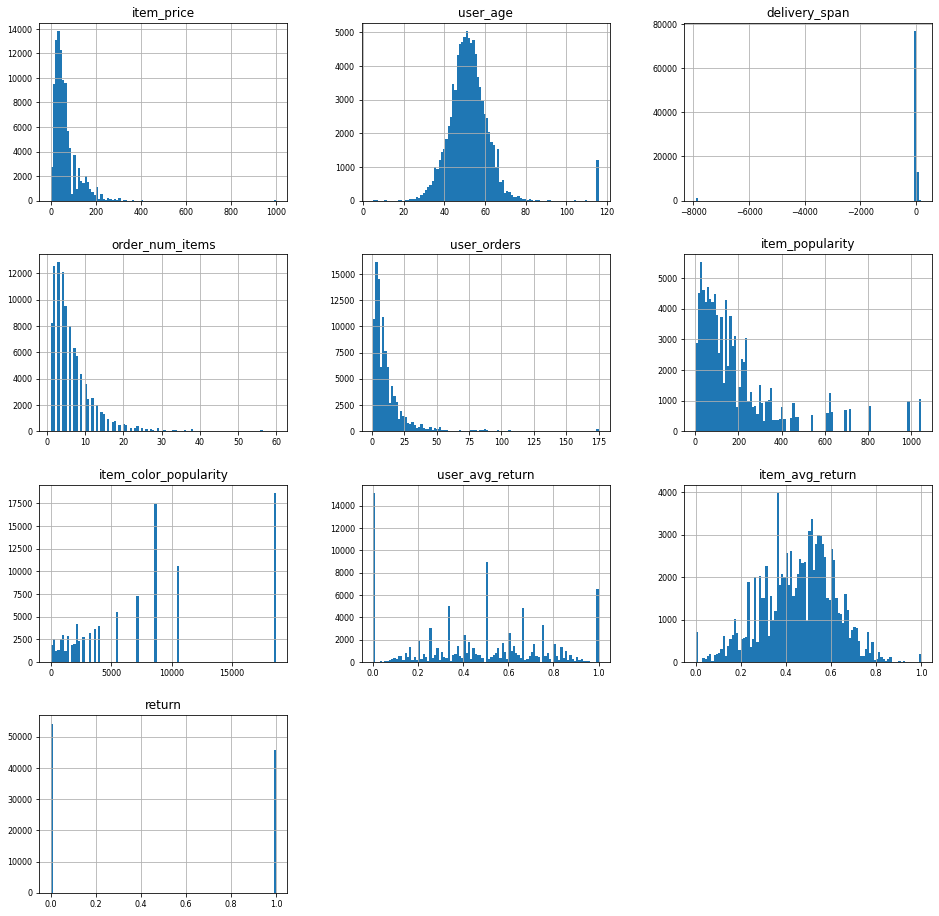

In [31]:
df_known.hist(figsize=(16, 16), bins=100, xlabelsize=8, ylabelsize=8); # produces one histogram per feature

We can see that there some outliers in some of the features. Also some of the distributions are skewed right.

### Handling of gaps and outliers
We will fill the gaps in `user_age` and `delivery_span` with the median of their values in the training set.
We also do not believe that our customers are less than 16 or more than a 100 years old. Therefore we will also assign those users the user age median of the training data. We do the same with the negative values for `delivery_span`.<br/>
We will handle the other outliers with upper bounds. We will assign it to every value that exceeds it. The upper bounds are as follows:
- `item_price`:      400
- `delivery_span`:   50
- `order_num_items`: 40
- `user_orders`:     100

In [32]:
df_known = transformer.clean(df_known)

### Handling skewness
We will try to handle the skewness of the features `item_price`, `order_num_items`, `user_orders`, `item_popularity` and `item_color_popularity` by applying the function `log(x+1)` to them. The addition of 1 inside the log function is important, as some of the features have value 0.

In [33]:
df_known = transformer.unskew(df_known)

### Correlations of features and target
Because we created dependent features, we want to train our transformer and then inspect the correlations on our test data. In order to do this, we split our data into a training and a test set.

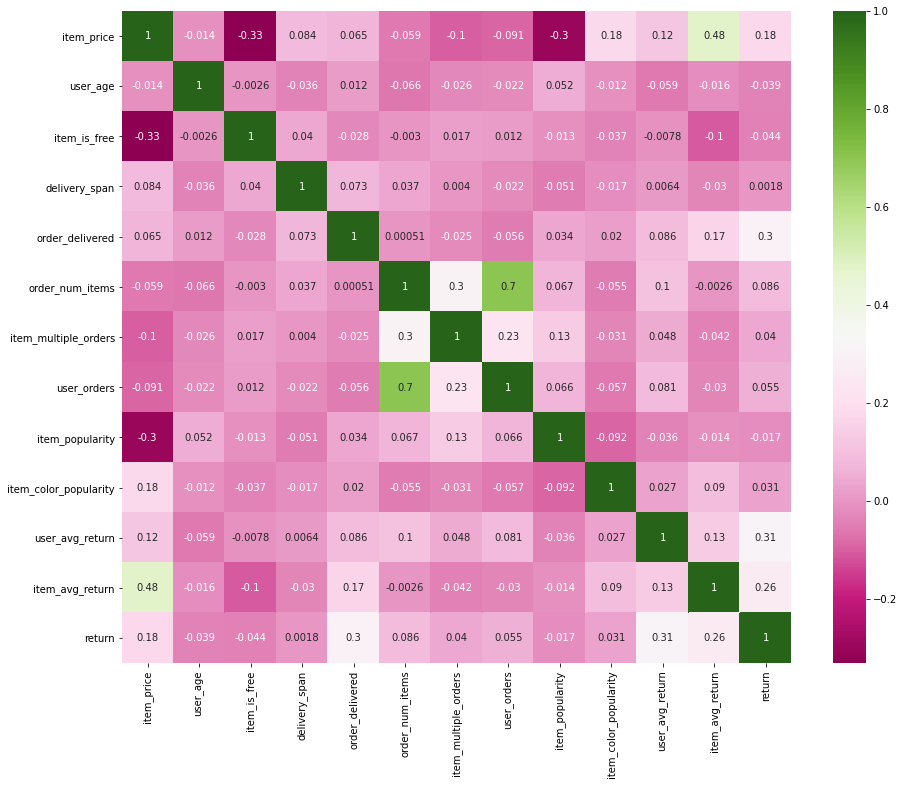

In [34]:
df_known = pd.read_csv("BADS_WS2021_known.csv", index_col='order_item_id')
X = df_known.drop('return', axis=1).copy()
y = df_known['return'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

X_train = transformer.fit_transform(X_train, y_train)

X_test = transformer.transform(X_test)

X_all = pd.concat([X_test,y_test], axis=1)


corr = X_all.corr()

fig, ax = plt.subplots(figsize=(15, 12))


sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True,
            cmap="PiYG");

There is some autocorrelation in our features, which is generally bad. However, the correlations are not too extreme. <br/>
What is very good to see, on the other hand, is that some of our features have a fairly high correlation to our target value. They promise to be great predictors.

## Modelling
Now that we have prepared our data, we want to find a good prediction model.
We will find a model with optimal AUC and then search for the threshold is expected to minimize cost.
Before testing different estimators, we will always apply our transformations to prepare the data and then apply a `StandardScaler` to scale the data.

We will try to use Logistic Regression with Elastic net regularization. We will perform a gridsearch to find the best parameters for the regularization parameter `C` and the ratio of Lasso-Regularization `l1_ratio`.

In [36]:
transformer = DataTransformer()
scaler = StandardScaler()

logit_pipe = Pipeline([
            ('transformer', transformer), # ('step_name', transfomer) always follow this format for transformers in the pipeline
            ('scaler', StandardScaler()),
            ('logistic', LogisticRegression(penalty='elasticnet', solver='saga', random_state=seed, fit_intercept=True)) # ('step_name', fun()) add parantheses for other functions
            ])

C_values = [0.6, 0.8, 1, 1.2, 1.4]
l1_ratios = [0.3, 0.5, 0.7]
num_splits = 3


y = df_known['return'].copy()
X = df_known.drop('return', axis=1).copy()


best_auc = 0

auc_list = []


for split in range(num_splits):

    # Split data into training and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed+split)
    
    X_train = transformer.fit_transform(X_train, y_train)
    X_train = scaler.fit_transform(X_train)
    
    X_test = transformer.transform(X_test)
    X_test = scaler.transform(X_test)
    
    for C in C_values:
        for l1_ratio in l1_ratios:
            logit = LogisticRegression(penalty='elasticnet', solver='saga',
                                            C=C, l1_ratio=l1_ratio,
                                            random_state=seed, max_iter=200) # ('step_name', fun()) add parantheses for other functions
            logit.fit(X_train, y_train)
            y_probs = logit.predict_proba(X_test)[:,1]
            auc = roc_auc_score(y_test, y_probs)
            auc_list.append(auc)
            if auc > best_auc:
                best_auc = auc
                best_params_logit = {'C': C, 'l1_ratio': l1_ratio}
                
print("The best parameters are:")
print(best_params_logit)
print("The best AUC score is {}".format(best_auc))
print("The standard deviation of all AUC values is {}".format(np.std(auc_list)))

The best parameters are:
{'C': 0.8, 'l1_ratio': 0.3}
The best AUC score is 0.7650149102565651
The standard deviation of all AUC values is 0.0009461665625776799


Now, we will try to use a Random Forest Classifier and search over the parameters `n_estimators`, `criterion` and `max_depths`.

In [37]:
transformer = DataTransformer()
scaler = StandardScaler()

n_estimators_list = [10, 30, 50, 100]
criteria = ['gini', 'entropy']
max_depths = [1,2,5,10]

num_splits = 3

best_auc = 0

auc_list = []

y = df_known['return'].copy()
X = df_known.drop('return', axis=1).copy()

for split in range(num_splits):

    # Split data into training and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed+split)
    
    X_train = transformer.fit_transform(X_train, y_train)
    X_train = scaler.fit_transform(X_train)
    
    X_test = transformer.transform(X_test)
    X_test = scaler.transform(X_test)
    
    for n_estimators in n_estimators_list:
        for criterion in criteria:
            for max_depth in max_depths:
                rfc = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth,
                                             random_state=seed)
                rfc.fit(X_train, y_train)
                y_probs = rfc.predict_proba(X_test)[:,1]
                auc = roc_auc_score(y_test, y_probs)
                auc_list.append(auc)
                if auc > best_auc:
                    best_auc = auc
                    best_params_rfc = {'n_estimators': n_estimators, 'criterion': criterion, 'max_depth': max_depth}

print("The best parameters are:")
print(best_params_rfc)
print("The best AUC score is {}".format(best_auc))
print("The standard deviation of all AUC values is {}".format(np.std(auc_list)))


The best parameters are:
{'n_estimators': 30, 'criterion': 'gini', 'max_depth': 2}
The best AUC score is 0.7612823395409543
The standard deviation of all AUC values is 0.01093890516730509


The AUC values for both models with every parameter combination are extremely similar. It is disappointing that we do not gain any improvement by model tuning. On the other hand, the models are very consistent. <br/>

We will decide to use Logistic Regression with its best parameters in our model.

### Finding a prediciton threshold that minimizes costs
We will use the function `calculate_costs` to calculate the cost of binary prediction. Using this function, we will perform a grid search over possible threshold values and find the threshold that minimizes our costs with function `find_optimal_threshold`.

In [38]:
def calculate_costs(X, y, y_pred):
    costs = 0
    differences = y-y_pred
    fn = differences == 1
    fp = differences == -1
    
    X.reset_index()
    costs += X.loc[fp, 'item_price'].sum() * 0.5
    costs += X.loc[fn, 'item_price'].sum() * 0.25
    costs += np.sum(fn) * 7.5
    
    return costs.round(2)


def find_optimal_threshold(X, y, y_probs):
    best_threshold = 0
    lowest_cost = np.inf
    for threshold in np.linspace(0, 1, 101):
        y_pred = y_probs > threshold
        cost = calculate_costs(X, y, y_pred)
        if cost < lowest_cost:
            lowest_cost = cost
            best_threshold = threshold
    
    return best_threshold, lowest_cost

Now, we will use our defined functions. We will split our dataset 5 times in order to avoid variability. Our final threshold will be computed as the average of the 5 thresholds computed.

In [40]:
model = Model(LogisticRegression(penalty='elasticnet', solver='saga',random_state=seed, max_iter=200,
                                 C=best_params_logit['C'], l1_ratio=best_params_logit['l1_ratio']))

model = Pipeline([
            ('c', DataTransformer()), # ('step_name', transfomer) always follow this format for transformers in the pipeline
            ('scaler', StandardScaler()),
            ('logit', LogisticRegression(penalty='l2', fit_intercept=True)) # ('step_name', fun()) add parantheses for other functions
            ])

data = pd.read_csv("BADS_WS2021_known.csv", index_col='order_item_id')

y = data['return'].copy()
X = data.drop('return', axis=1).copy()

num_splits = 5
test_percentage = 0.3

best_thresholds = []
lowest_costs = []

for iteration in range(num_splits):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_percentage, random_state=seed+iteration)
    model.fit(X_train,y_train)
    y_probs = model.predict_proba(X_test)[:,1]
    best_threshold, lowest_cost = find_optimal_threshold(X_test, y_test, y_probs)
    best_thresholds.append(best_threshold)
    lowest_costs.append(lowest_cost)
    
final_threshold = np.mean(best_thresholds).round(2)
lowest_costs = np.array(lowest_costs)
lowest_costs = lowest_costs / (len(X)*test_percentage)
final_costs = np.mean(lowest_costs).round(2)

print("The best threshold is {} with a standard deviation of {}.".format(final_threshold, np.std(best_thresholds).round(2)))
print("The average costs per item are {}€ with a standard deviation of {}€.".format(final_costs, np.std(lowest_costs).round(2)))

The best threshold is 0.56 with a standard deviation of 0.01.
The average costs per item are 8.96€ with a standard deviation of 0.04€.


## Prediction of the unknown values
Now that we have our model and an optimal prediction threshold to minimize cost, we will train our model on all the known data points and make a prediction of the unknown values.

In [41]:
model = Model(LogisticRegression(penalty='l2', fit_intercept=True))
model.fit(X,y)
y_preds = model.predict(df_unknown, final_threshold)

In [42]:
predictions = pd.Series(y_preds, index=df_unknown.index, name='return') 

In [43]:
predictions.to_csv('final_predictions.csv')

## Conclusion

The prediction of item returns is a difficult task. We found a good way to minimize cost, but the average cost in our dataset is still nearly 9€. In the end, the decision to return an item is often dependent on the taste of the customer and other factors that we can not observe. Still, our model should still be helpful to our retail company. <br/>
There are some more interesting approaches to tackle the problem that we did not pursuit. For example, it would be interesting to use a Neural Network as our estimator. Also, one could use a clustering algorithm on users or items to engineer better features. Theses approaches could improve the results further.